# HM1: Logistic Regression.

### Name: [Jian Hui Mai]


#### For this assignment, you will build 6 models. You need to train Logistic Regression/Regularized Logistic Regression each with Batch Gradient Descent, Stochastic Gradient Descent and Mini Batch Gradient Descent. Also you should plot their objective values versus epochs and compare their training and testing accuracies. You will need to tune the parameters a little bit to obtain reasonable results.

#### You do not have to follow the following procedure. You may implement your own functions and methods, but you need to show your results and plots.

In [1]:
# Load Packages
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Data processing

- Download the Breast Cancer dataset from canvas or from https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)
- Load the data.
- Preprocess the data.

## 1.1. Load the data

In [2]:
# Store data into data frame
df = pd.read_csv ('data.csv')

## 1.2 Examine and clean data

In [3]:
# Some columns may not be useful for the model (For example, the first column contains ID number which may be irrelavant). 
# You need to get rid of the ID number feature.
# Also you should transform target labels in the second column from 'B' and 'M' to 1 and -1.

# Drop the first column called ID
df = df.drop('id', 1)
# Remove the last unnamed column
df = df.dropna(how='all', axis='columns')

# Change diagnosis values to 1 and -1 for B and M respectfully
df.loc[df['diagnosis'] == 'B', 'diagnosis'] = 1
df.loc[df['diagnosis'] == 'M', 'diagnosis'] = -1

C:\Users\Jian\AppData\Local\Temp/ipykernel_21480/1508538230.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('id', 1)


## 1.3. Partition to training and testing sets

In [4]:
# You can partition using 80% training data and 20% testing data. It is a commonly used ratio in machinel learning.

# Split training and testing set
train, test = train_test_split(df, test_size=0.2)
# Y train contains only diagnosis column
y_train = train[['diagnosis']]
# X train contains every column minus diagnosis
x_train = train.drop(['diagnosis'], axis=1)

# Y test contains only diagnosis
y_test = test[['diagnosis']]
# X tests contains every column minus diagnosis 
x_test = test.drop(['diagnosis'], axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (455, 30)
Shape of x_test: (114, 30)
Shape of y_train: (455, 1)
Shape of y_test: (114, 1)


## 1.4. Feature scaling

Use the standardization to transform both training and test features

In [5]:
# Standardization
import numpy as np

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = np.mean(x_train, axis=0).values.reshape(1, d)
sig = np.std(x_train, axis=0).values.reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(np.mean(x_test, axis=0))

print()

print('test std = ')
print(np.std(x_test, axis=0))

test mean = 
radius_mean               -0.159491
texture_mean              -0.032848
perimeter_mean            -0.167532
area_mean                 -0.130670
smoothness_mean           -0.003247
compactness_mean          -0.181639
concavity_mean            -0.183276
concave points_mean       -0.165604
symmetry_mean             -0.113534
fractal_dimension_mean    -0.073266
radius_se                 -0.027190
texture_se                 0.147856
perimeter_se              -0.065763
area_se                   -0.060378
smoothness_se              0.133298
compactness_se            -0.197153
concavity_se              -0.121722
concave points_se         -0.130580
symmetry_se               -0.160218
fractal_dimension_se      -0.084156
radius_worst              -0.114597
texture_worst             -0.054910
perimeter_worst           -0.139220
area_worst                -0.078198
smoothness_worst          -0.012998
compactness_worst         -0.218936
concavity_worst           -0.167726
concave points_

# 2.  Logistic Regression Model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

When $\lambda = 0$, the model is a regular logistric regression and when $\lambda > 0$, it essentially becomes a regularized logistric regression.

In [6]:
# Calculate the objective function value, or loss
# Inputs:
#     w: weight: d-by-1 matrix
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: regularization parameter: scalar
# Return:
#     objective function value, or loss (scalar)
def objective(w, x, y, lam):
    # Retrieve x value of data matrix
    n = x.shape[0]
    # Convert x and y into matrices then do a elementwise multiplication
    yx = np.multiply(np.mat(y),np.mat(x))
    # Dot multiplication on w and the result above
    yxw = np.dot(yx, w)
    # Convert to float
    yxw = yxw.astype(float)
    # Multiply e to all -yxw
    eyxw = np.exp(-yxw)
    # Perform log operation 
    log = np.log(1 + eyxw)
    # Regularization formula
    regularization = (lam/2) * np.sum(np.multiply(w,w))
    # The mean of the log formula added by regularization term
    objective_function = np.mean(log) + regularization
    return objective_function

# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ for regularized logistic regression is  $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [7]:
# Calculate the gradient
# Inputs:
#     w: weight: d-by-1 matrix
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: regularization parameter: scalar
# Return:
#     g: gradient: d-by-1 matrix
def gradient(w, x, y, lam):
    # Convert y and x to matrices and then do elementwise multiplication
    numerator = np.multiply(np.mat(y),np.mat(x))
    # Multiply result above with w vector
    yxw = np.dot(numerator,w)
    # Convert above result to a float
    yxw = yxw.astype(float)
    # Formula for denominator
    denominator = 1 + np.exp(yxw)
    # Divide the numerator and denominator then apply the negative mean 
    vec = -np.mean(np.divide(numerator,denominator), axis=0).reshape(d, 1)
    # Add result above to regularization term
    g = vec + lam * w
    return g

In [8]:
# Gradient descent for solving logistic regression
# You will need to do iterative process (loops) to obtain optimal weights in this function

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value
def gradient_descent(x, y, lam, learning_rate, w, max_epoch=100):
    # Holds number of epochs
    count = 0 
    # Retrieve shape of x matrix
    n = x.shape[0]
    d = x.shape[1]
    
    # List to hold objvals
    objvals = []
    # Iteration continues when count is less than max epoch
    while count < max_epoch:
        # Variable to hold ouptut after calculating objective value
        objval = objective(w,x,y,lam)
        # Add the output to lise
        objvals.append(objval)
        # Variable to hold output of gradient function
        grad = gradient(w, x, y, lam)
        # Increment epoch
        count = count + 1
        # Temp variable to hold learning * gradient
        temp = learning_rate * grad
        # Update weights to be learning_rate * gradient minus current weight
        w = np.subtract(w, temp)
    objvals = np.array(objvals)
    # Return the w matrix and objval as an array
    return w, objvals

Use gradient_descent function to obtain your optimal weights and a list of objective values over each epoch.

In [9]:
# Train logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
lam = 0
learning_rate = 0.1

# Retrieve d of x_train 
d = x_train.shape[1]
# Create a weight vector of 0s
w = np.zeros((d, 1))

w_gd, objvals_gd = gradient_descent(x_train, y_train, lam, learning_rate, w)

In [10]:
# Train regularized logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
lam = 0.5
learning_rate = 0.1

# Retrieve d of x_train
d = x_train.shape[1]
# Create a weight vector of 0s
w = np.zeros((d, 1))

w_rgd, objvals_rgd = gradient_descent(x_train, y_train, lam, learning_rate, w)

## 3.2. Stochastic gradient descent (SGD)

Define new objective function $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $. 

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

You may need to implement a new function to calculate the new objective function and gradients.

In [11]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: weights: d-by-1 matrix
#     xi: data: 1-by-d matrix
#     yi: label: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    # Element wise multiply the first index of Yi only with Xi
    yx = np.multiply(yi[0],xi)
    # Dot multiply yx output and weight matrix
    yxw = np.dot(yx, w)
    # Apply e to -yxw
    eyxw = np.exp(-yxw)
    # Apply log formula
    log = np.log(1 + eyxw)
    # Regularization function for objective function
    regularization = (lam/2) * np.sum(np.multiply(w,w))
    obj = log + regularization
    
    # Loss formula
    loss = -yx / (1 + np.exp(yxw)) 
    # Apply gradient function
    g = loss + (lam * w)
    # Return obj and g 
    return obj, g

Hints:
1. In every epoch, randomly permute the $n$ samples.
2. Each epoch has $n$ iterations. In every iteration, use 1 sample, and compute the gradient and objective using the ``stochastic_objective_gradient`` function. In the next iteration, use the next sample, and so on.

In [12]:
# SGD for solving logistic regression
# You will need to do iterative process (loops) to obtain optimal weights in this function

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value
#     Record one objective value per epoch (not per iteration)
def sgd(x, y, lam, learning_rate, w, max_epoch=100):
    # Hold number of epochs
    count = 0 
    
    # Retrive dimensions of x matrix
    n = x.shape[0]
    d = x.shape[1]
    
    # List to hold objvals
    objvals = []
    
    # Convert x and y dataframe to numpy array
    x = x.to_numpy()
    y = y.to_numpy()
    
    while count < max_epoch:
        # Used to randomize each sample per epoch
        np.random.shuffle(x)   
        np.random.shuffle(y)
        
        # Initialization of objval value
        objval = 0
        
        for i in range(n):
            # Create new numpy array with subset of all values of i rows to end 
            xi = x[i, :]
            yi = y[i, :]
            
            # Function call to stochastic_objective_gradient
            objective_function, gradient = stochastic_objective_gradient(w, xi, yi, lam)
            # Matrix addition of objval and objective function
            objval = np.add(objval, objective_function)
            # Temp variable to hold learning rate * gradient
            temp = learning_rate * gradient
            # W matrix subtracted by temp
            w = np.subtract(w, temp)
            
        # Divide objval value by n since it is only 1 row
        objval = objval / n
        # Add objval to list
        objvals.append(objval)
        # Increment epoch
        count = count + 1
    # Reshape the w vector
    w = w.reshape(d,1)
    # Change objvals to np array
    objvals = np.array(objvals)
    return w, objvals

Use sgd function to obtain your optimal weights and a list of objective values over each epoch.

In [13]:
# Train logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
lam = 0
learning_rate = 0.1

# Retrieve d of x_train
d = x_train.shape[1]
# Create weight vector of d x 1
w = np.zeros(d)
w_sgd, objvals_sgd = sgd(x_train, y_train, lam, learning_rate, w)

In [14]:
# Train regularized logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
lam = 0.5
learning_rate = 0.1

# Retrieve d of x_train
d = x_train.shape[1]
# Create weight vector of d x 1
w = np.zeros(d)
w_rsgd, objvals_rsgd = sgd(x_train, y_train, lam, learning_rate, w)

## 3.3 Mini-Batch Gradient Descent (MBGD)

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

You may need to implement a new function to calculate the new objective function and gradients.

In [15]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: weights: d-by-1 matrix
#     xi: data: b-by-d matrix
#     yi: label: b-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_objective_gradient(w, xi, yi, lam):
    # Retrieve dimension of xi
    b = xi.shape[0]
    d = xi.shape[1]

    # Element wise multiply of matrix yi and matrix xi 
    yx = np.multiply(np.mat(yi),np.mat(xi))
    # Dot multiply result above and w
    yxw = np.dot(yx, w)
    # Convert to float
    yxw = yxw.astype(float)
    # e to all values of -yxw
    eyxw = np.exp(-yxw)
    
    # Mean after log of 1  + exyw
    log = np.mean(np.log(1 + eyxw))
    # Regularization term 
    regularization = (lam/2) * np.sum(np.multiply(w,w))
    # Objective function 
    obj = log + regularization
    
    loss = np.mean(np.divide(-yx,(1 + np.exp(yxw))), axis=0).reshape(d, 1)
    g = loss + (lam * w)
    
    return obj, g

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.

In [16]:
# MBGD for solving logistic regression
# You will need to do iterative process (loops) to obtain optimal weights in this function

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value
#     Record one objective value per epoch (not per iteration)
import random
def mbgd(x, y, lam, learning_rate, w, max_epoch=100):
    # used to hold number of epochs
    count = 0 
    # Retrieve dimensions for x matrix
    n = x.shape[0]
    d = x.shape[1]
    # list to hold objvals
    objvals = []
    # Convert x and y to numpy array
    x = x.to_numpy()
    y = y.to_numpy()

    while count < max_epoch:
        # Used to randomize each sample per epoch
        np.random.shuffle(x)   
        np.random.shuffle(y)
        
        # Intialize/rest objval value
        objval = 0
        
        # Generate a random number between 1 and n
        num = random.randint(1, n)
        # If num is not divisible, generate a new number
        if (n % num !=0):
            num = generate_new_number(n, num)
        # Number of batches
        batches = int(n/num)
        # Iterate through each batch
        for i in range(batches):
            # Start index
            start = i * num
            # If random num is not 1, end index is ((i+1) * num) -1
            if num != 1:
                end = (((i+1)*num)-1)
            # if random num is 1, end is the next element
            elif num == 1: 
                end = start + 1
            # Create new np array based on start and end indexes
            xi = x[start:end,]
            yi = y[start:end,]
            
            # call mini batch objective gradient function 
            objective_function, gradient = mb_objective_gradient(w, xi, yi, lam)
            # Matrix addition of objval and objective function
            objval = np.add(objval, objective_function)
            # Temp variable to hold learning rate * gradient
            temp = learning_rate * gradient
            # W matrix subtracted by temp
            w = np.subtract(w, temp)
        # Get objval value which is objval/number of batches
        objval = objval / batches
        # Add objval value to list
        objvals.append(objval)
        # Incriment epoch
        count = count + 1
    # Convert list to np array
    objvals = np.array(objvals)
    return w, objvals

# Used to generate a new random number if it is not divisible
def generate_new_number(n, num):
    # Generate new number
    num = random.randint(1, n)
    # if number not divisible, call function again to generate
    if (n % num !=0):
        return generate_new_number(n, num)
    # else return the num
    else: 
        return num

Use mbgd function to obtain your optimal weights and a list of objective values over each epoch.

In [17]:
# Train logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
lam = 0
learning_rate = 0.1

# Retrieve d of x_train
d = x_train.shape[1]
# Generate weight vector of 0s
w = np.zeros((d, 1))

w_mbgd, objvals_mbgd = mbgd(x_train, y_train, lam, learning_rate, w)

In [18]:
# Train regularized logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
lam = 0.5
learning_rate = 0.1

# Retrieve d of x_train
d = x_train.shape[1]
# Generate weight vector of 0s
w = np.zeros((d, 1))

w_rmbgd, objvals_rmbgd = mbgd(x_train, y_train, lam, learning_rate, w)

# 4. Compare GD, SGD, MBGD

### Plot objective function values against epochs.

C:\Users\Jian\AppData\Local\Temp/ipykernel_21480/120115234.py:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  gd, = plt.plot(range(len(objvals_gd)), objvals_gd, '--b', LineWidth=4)
C:\Users\Jian\AppData\Local\Temp/ipykernel_21480/120115234.py:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  rgd, = plt.plot(range(len(objvals_rgd)), objvals_rgd, '--g', LineWidth=4)
C:\Users\Jian\AppData\Local\Temp/ipykernel_21480/120115234.py:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  sgd_graph, = plt.plot(range(len(objvals_sgd)), objvals_sgd, '-r', LineWidth=4)
C:\Users\Jian\AppData\Local\Temp/ipykernel_21480/120115234.py:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed

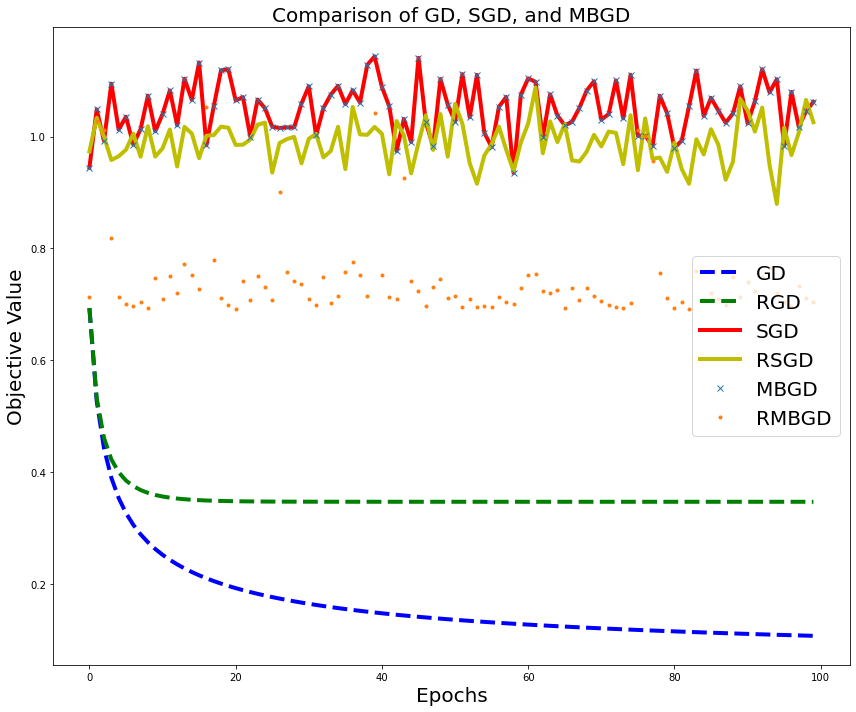

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(12, 10))

gd, = plt.plot(range(len(objvals_gd)), objvals_gd, '--b', LineWidth=4)
rgd, = plt.plot(range(len(objvals_rgd)), objvals_rgd, '--g', LineWidth=4)
sgd_graph, = plt.plot(range(len(objvals_sgd)), objvals_sgd, '-r', LineWidth=4)
rsgd, = plt.plot(range(len(objvals_rsgd)), objvals_rsgd, '-y', LineWidth=4)
mbgd_graph, = plt.plot(range(len(objvals_mbgd)), objvals_sgd, 'x', LineWidth=4)
rmbgd, = plt.plot(range(len(objvals_rmbgd)), objvals_rmbgd, '.', LineWidth=4)
plt.title('Comparison of GD, SGD, and MBGD', FontSize=20)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.legend([gd, rgd, sgd_graph, rsgd, mbgd_graph, rmbgd], ['GD', 'RGD', 'SGD', 'RSGD', 'MBGD', 'RMBGD'], fontsize=20)
plt.tight_layout()
plt.show()

#### It appears that GD has the lowest objective value while SGD and MBGD has the highest objective value after 100 epochs.

# 5. Prediction
### Compare the training and testing accuracy for logistic regression and regularized logistic regression.

In [20]:
# Predict class label
# Inputs:
#     w: weights: d-by-1 matrix
#     X: data: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    # Retreive d of weight vector
    d = w.shape[0]
    # Elementwise multiply x and w (transposed)
    mult = np.multiply(np.mat(X), np.mat(w.T))
    # Add each row
    sum_of_rows = np.sum(mult, axis = 1)
    return sum_of_rows

In [21]:
# Function to calculate MSE error
def calculate_error(prediction, true_value):
    # Find the difference between true value and prediction matrix
    difference = np.subtract(true_value, prediction)
    # Square differences
    squared = np.square(difference)
    # mean of the sum of differences
    mean = np.mean(np.sum(squared))
    return mean

In [22]:
# evaluate training error of logistic regression and regularized version
print("Training Error")
gdp = predict(w_gd, x_train)
rgdp = predict(w_rgd, x_train)
print("MSE of Logistic GD: " + str(calculate_error(gdp, y_train)))
print("MSE of Regularized GD: " + str(calculate_error(rgdp, y_train)))

print('\n')

sgdp = predict(w_sgd, x_train)
rsgdp = predict(w_rsgd, x_train)
print("MSE of Logistic SGD: " + str(calculate_error(sgdp, y_train)))
print("MSE of Regularized SGD: " + str(calculate_error(rsgdp, y_train)))

print('\n')

mbgdp = predict(w_mbgd, x_train)
rmbgdp = predict(w_rmbgd, x_train)
print("MSE of Logistic MBGD: " + str(calculate_error(mbgdp, y_train)))
print("MSE of Regularized MBGD: " + str(calculate_error(rmbgdp, y_train)))

Training Error
MSE of Logistic GD: 12955.314300700278
MSE of Regularized GD: 2508.4056229037606


MSE of Logistic SGD: 793.0126557841837
MSE of Regularized SGD: 617.085542678522


MSE of Logistic MBGD: 478.37422587040646
MSE of Regularized MBGD: 455.56174899582857


In [23]:
# evaluate testing error of logistic regression and regularized version
print("Testing Error")
gdp = predict(w_gd, x_test)
rgdp = predict(w_rgd, x_test)
print("MSE of Logistic GD: " + str(calculate_error(gdp, y_test)))
print("MSE of Regularized GD: " + str(calculate_error(rgdp, y_test)))

print('\n')

sgdp = predict(w_sgd, x_test)
rsgdp = predict(w_rsgd, x_test)
print("MSE of Logistic SGD: " + str(calculate_error(sgdp, y_test)))
print("MSE of Regularized SGD: " + str(calculate_error(rsgdp, y_test)))

print('\n')

mbgdp = predict(w_mbgd, x_test)
rmbgdp = predict(w_rmbgd, x_test)
print("MSE of Logistic MBGD: " + str(calculate_error(mbgdp, y_test)))
print("MSE of Regularized MBGD: " + str(calculate_error(rmbgdp, y_test)))

Testing Error
MSE of Logistic GD: 1972.054361576398
MSE of Regularized GD: 180.49737229800286


MSE of Logistic SGD: 266.7558197860301
MSE of Regularized SGD: 82.99787794696825


MSE of Logistic MBGD: 117.8382294151166
MSE of Regularized MBGD: 116.89983211589114


#### It appears that Regularized MBGD has the lowest Training Error MSE while Regularized SGD has the lowest Testing Error MSE.

# 6. Parameters tuning

### In this section, you may try different combinations of parameters (regularization value, learning rate, etc) to see their effects on the model. (Open ended question)

In [24]:
learning_rate = 0.01
# Retrieve d of x_train 
d = x_train.shape[1]
# Create a weight vector of 0s
w = np.zeros((d, 1))
w1 = np.zeros(d)

# Train logistic regression
lam = 0
w1_gd, objvals1_gd = gradient_descent(x_train, y_train, lam, learning_rate, w)
w1_sgd, objvals1_sgd = sgd(x_train, y_train, lam, learning_rate, w1)
w1_mbgd, objvals1_mbgd = mbgd(x_train, y_train, lam, learning_rate, w)

# Train regularized logistic regression
lam = 0.5
w1_rgd, objvals1_rgd = gradient_descent(x_train, y_train, lam, learning_rate, w)
w1_rsgd, objvals1_rsgd = sgd(x_train, y_train, lam, learning_rate, w1)
w1_rmbgd, objvals1_rmbgd = mbgd(x_train, y_train, lam, learning_rate, w)


print("Testing Error")
gdp1 = predict(w1_gd, x_test)
rgdp1 = predict(w1_rgd, x_test)
print("MSE of Logistic GD: " + str(calculate_error(gdp1, y_test)))
print("MSE of Regularized GD: " + str(calculate_error(rgdp1, y_test)))

print('\n')

sgdp1 = predict(w1_sgd, x_test)
rsgdp1 = predict(w1_rsgd, x_test)
print("MSE of Logistic SGD: " + str(calculate_error(sgdp1, y_test)))
print("MSE of Regularized SGD: " + str(calculate_error(rsgdp1, y_test)))

print('\n')

mbgdp1 = predict(w1_mbgd, x_test)
rmbgdp1 = predict(w1_rmbgd, x_test)
print("MSE of Logistic MBGD: " + str(calculate_error(mbgdp1, y_test)))
print("MSE of Regularized MBGD: " + str(calculate_error(rmbgdp1, y_test)))

Testing Error
MSE of Logistic GD: 110.95146584338498
MSE of Regularized GD: 106.62100436601997


MSE of Logistic SGD: 203.2644988551427
MSE of Regularized SGD: 169.89107343079047


MSE of Logistic MBGD: 149.24917699085313
MSE of Regularized MBGD: 110.41778242183508


In [25]:
learning_rate = 0.1

# Train logistic regression
lam = 0
w2_gd, objvals2_gd = gradient_descent(x_train, y_train, lam, learning_rate, w)
w2_sgd, objvals2_sgd = sgd(x_train, y_train, lam, learning_rate, w1)
w2_mbgd, objvals2_mbgd = mbgd(x_train, y_train, lam, learning_rate, w)

# Train regularized logistic regression
lam = 0.8
w2_rgd, objvals2_rgd = gradient_descent(x_train, y_train, lam, learning_rate, w)
w2_rsgd, objvals2_rsgd = sgd(x_train, y_train, lam, learning_rate, w1)
w2_rmbgd, objvals2_rmbgd = mbgd(x_train, y_train, lam, learning_rate, w)


print("Testing Error")
gdp2 = predict(w2_gd, x_test)
rgdp2 = predict(w2_rgd, x_test)
print("MSE of Logistic GD: " + str(calculate_error(gdp2, y_test)))
print("MSE of Regularized GD: " + str(calculate_error(rgdp2, y_test)))

print('\n')

sgdp2 = predict(w2_sgd, x_test)
rsgdp2 = predict(w2_rsgd, x_test)
print("MSE of Logistic SGD: " + str(calculate_error(sgdp2, y_test)))
print("MSE of Regularized SGD: " + str(calculate_error(rsgdp2, y_test)))

print('\n')

mbgdp2 = predict(w2_mbgd, x_test)
rmbgdp2 = predict(w2_rmbgd, x_test)
print("MSE of Logistic MBGD: " + str(calculate_error(mbgdp2, y_test)))
print("MSE of Regularized MBGD: " + str(calculate_error(rmbgdp2, y_test)))

Testing Error
MSE of Logistic GD: 117.90688046697606
MSE of Regularized GD: 113.67371972808596


MSE of Logistic SGD: 713.85252042158
MSE of Regularized SGD: 301.54966880630474


MSE of Logistic MBGD: 337.24696204213603
MSE of Regularized MBGD: 135.8060293846005


##### Changing the learning rate has dramatically decreased the MSE testing error for both logistic and regularized GD. Additionally, there was a lower logistic SGD, and regularized logistic MBGD. 

##### Changing the lam has resulted only in a lower logistic and regularized GD.